# **1. 資料集下載**

In [1]:
from google.colab import drive
drive.mount('MyDrive')

Mounted at MyDrive


In [2]:
import random
import os 

!unzip "/content/MyDrive/MyDrive/MidTerm_Dataset.zip"
!echo 'unzip success'

串流輸出內容已截斷至最後 5000 行。
  inflating: MidTerm_Dataset/Train/bolt/573.png  
  inflating: MidTerm_Dataset/Train/bolt/574.png  
  inflating: MidTerm_Dataset/Train/bolt/575.png  
  inflating: MidTerm_Dataset/Train/bolt/576.png  
  inflating: MidTerm_Dataset/Train/bolt/577.png  
  inflating: MidTerm_Dataset/Train/bolt/578.png  
  inflating: MidTerm_Dataset/Train/bolt/579.png  
  inflating: MidTerm_Dataset/Train/bolt/580.png  
  inflating: MidTerm_Dataset/Train/bolt/581.png  
  inflating: MidTerm_Dataset/Train/bolt/582.png  
  inflating: MidTerm_Dataset/Train/bolt/583.png  
  inflating: MidTerm_Dataset/Train/bolt/584.png  
  inflating: MidTerm_Dataset/Train/bolt/585.png  
  inflating: MidTerm_Dataset/Train/bolt/586.png  
  inflating: MidTerm_Dataset/Train/bolt/587.png  
  inflating: MidTerm_Dataset/Train/bolt/588.png  
  inflating: MidTerm_Dataset/Train/bolt/589.png  
  inflating: MidTerm_Dataset/Train/bolt/590.png  
  inflating: MidTerm_Dataset/Train/bolt/591.png  
  inflating: MidTerm_Dataset/

# **2. 讀入封包**

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random

# **3. 取得資料集**

In [4]:
train_dir = './MidTerm_Dataset/Train/'
test_dir = './MidTerm_Dataset/Test/'
category_list = os.listdir(train_dir)
category_list

['nut', 'bolt', 'locatingpin', 'washer']

In [5]:
import glob
list_of_image = glob.glob(train_dir + "**/*.png")
list_of_folders = glob.glob(train_dir + "**")
num_image = len(list_of_image)
num_class = len(list_of_folders)
print("Total number of images " + str(num_image) ) # Total data
print("Total number of classes "+ str(num_class)) # Total Number of classes

Total number of images 6092
Total number of classes 4


In [6]:
mech_name = {}
# 建立將英文映射成數字的 dict。 EX: washer --> 0
def make_mech_name_dict():
  for i, name in enumerate(category_list):
    mech_name[name] = i
  return mech_name

class_name = make_mech_name_dict()
print (class_name)

# 建立將數字映射成英文的 dict。 EX: 0 --> washer
rev_class_name = {v: k for k, v in class_name.items()}
print (rev_class_name)

{'nut': 0, 'bolt': 1, 'locatingpin': 2, 'washer': 3}
{0: 'nut', 1: 'bolt', 2: 'locatingpin', 3: 'washer'}


training 畫作總共畫作有 :  6092


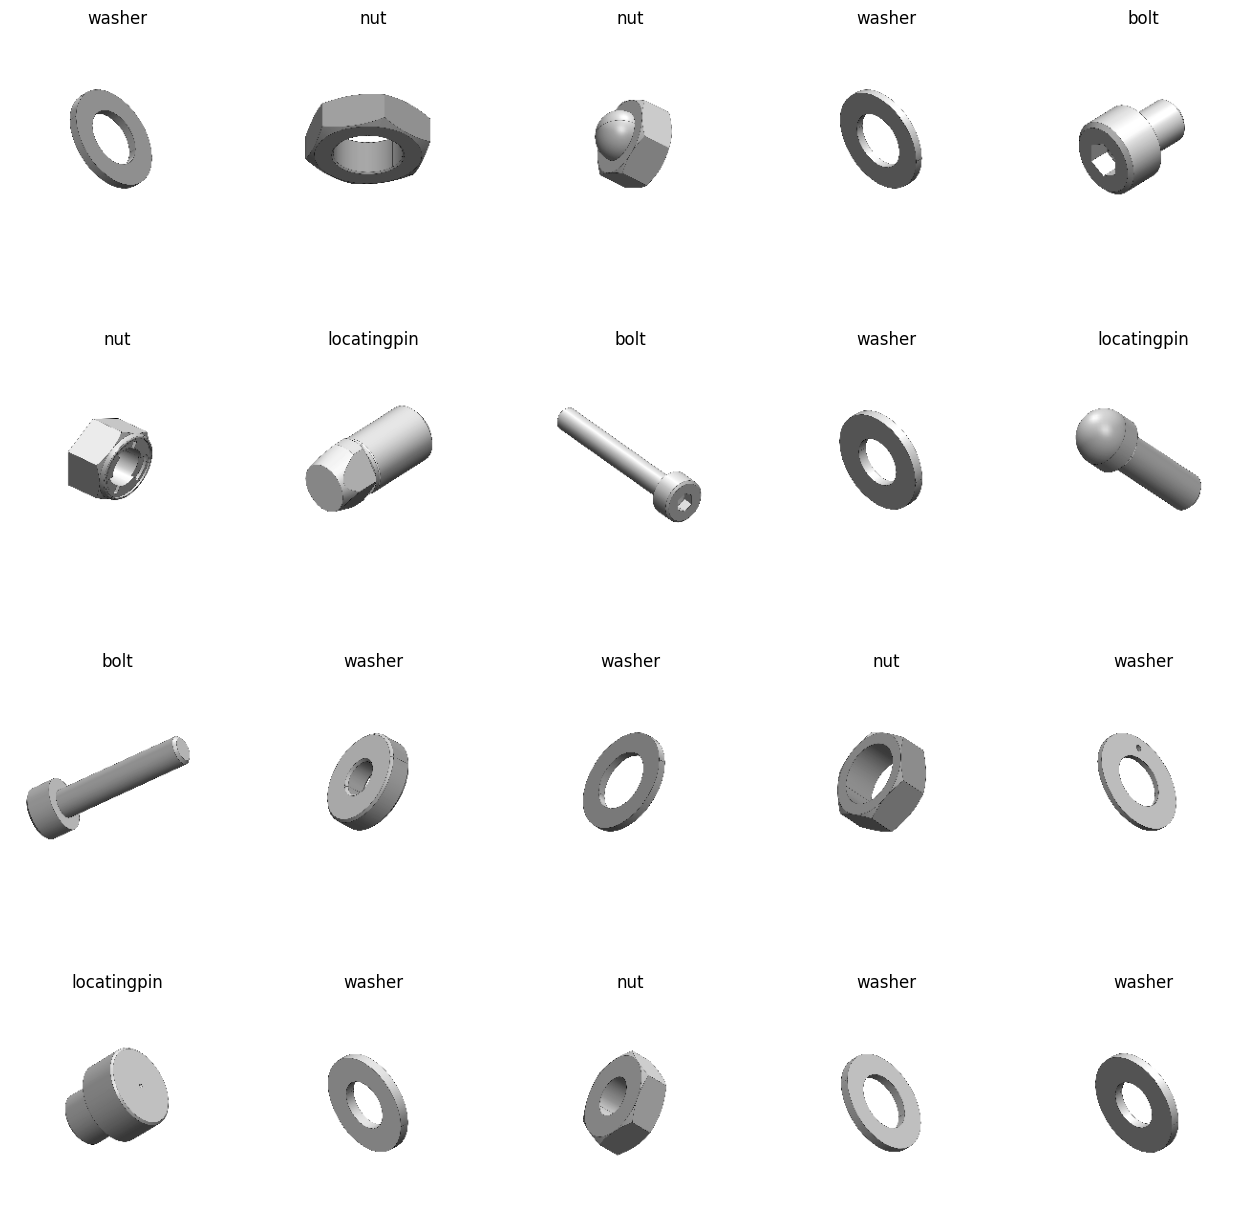

In [7]:
# 隨便印出20個圖片看看
random_list = random.sample(range(0, num_image), 20)
print("training 畫作總共畫作有 : ", num_image)

# Randomly select 20 images from the directory
random_list = random.sample(range(0, num_image), 20)

# Create a list of tuples containing the folder name and image path for each selected image
show_imgs = [(list_of_folders[class_name[imgName.split("/")[-2]]], imgName) for imgName in [list_of_image[rand] for rand in random_list]]

# Display the selected images with their folder names
plt.figure(figsize=(16, 16))
for index, (folder_name, img_path) in enumerate(show_imgs):
    img = cv.imread(img_path)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(4, 5, index + 1)
    plt.imshow(img_gray, cmap='gray')
    #plt.imshow(img)
    plt.title(folder_name.split("/")[-1])
    plt.axis("off")
    
plt.show()

# **4. 資料前處理**

In [8]:
def get_label(folder_name):
    label = folder_name.split("/")[-2]
    index = class_name[label]
    return index

def make_paths_label(img_list):
    paths = []
    labels = []

    for path in img_list:
        paths.append(path)
        labels.append(get_label(path))

    # Convert labels to one-hot encoding
    from tensorflow.keras.utils import to_categorical
    onehot_labels = to_categorical(labels, len(class_name))
    return paths, onehot_labels

In [9]:
paths, onehot_labels = make_paths_label(list_of_image)

print("paths : ")
for p in paths[:5]:
    print(p)
print("-" * 20)
print("labels : ")
for label in onehot_labels[:5]:
    print(label)

paths : 
./MidTerm_Dataset/Train/nut/1152.png
./MidTerm_Dataset/Train/nut/629.png
./MidTerm_Dataset/Train/nut/1707.png
./MidTerm_Dataset/Train/nut/489.png
./MidTerm_Dataset/Train/nut/1880.png
--------------------
labels : 
[1. 0. 0. 0.]
[1. 0. 0. 0.]
[1. 0. 0. 0.]
[1. 0. 0. 0.]
[1. 0. 0. 0.]


In [10]:
# 轉成 tensorflow dataset 格式，變成路徑 tensor
# from_tensor_slices 
paths_ds = tf.data.Dataset.from_tensor_slices(paths)
train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

print("turn to tensor")
for tensor in paths_ds.take(5):
    print(tensor)

turn to tensor
tf.Tensor(b'./MidTerm_Dataset/Train/nut/1152.png', shape=(), dtype=string)
tf.Tensor(b'./MidTerm_Dataset/Train/nut/629.png', shape=(), dtype=string)
tf.Tensor(b'./MidTerm_Dataset/Train/nut/1707.png', shape=(), dtype=string)
tf.Tensor(b'./MidTerm_Dataset/Train/nut/489.png', shape=(), dtype=string)
tf.Tensor(b'./MidTerm_Dataset/Train/nut/1880.png', shape=(), dtype=string)


In [11]:
# 決定輸入模型的圖片長寬 224
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_SIZE = None
# shuffle buffer size
SHUFFLE_BUFFER = 3000


def get_image(path):
    # read image from path
    file = tf.io.read_file(path)
    img = tf.io.decode_jpeg(file, channels=3)
    img = tf.cast(img, tf.float32)

    # 固定每張圖片大小為 IMG_HEIGHT、IMG_WIDTH
    # 並將圖片每個 pixel 映射到 [0,1] 之間

    img = tf.clip_by_value(img, 0.0, 254.0) / 254.0
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img

# 將所有資料轉成 Tensor -> Tensor 轉成圖片
# 圖片 Tensor 與 label Tensor Zip 起來成一個 pair
# shuffle 打散
def make_dataset(dir):
    paths, onehot_labels = make_paths_label(dir)
    paths_ds = tf.data.Dataset.from_tensor_slices(paths)
    train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

    # 將路徑 tensor 映射成圖片 tensor
    train_image = paths_ds.map(get_image)
    # 合併圖片與 label 資料集
    full_ds = tf.data.Dataset.zip((train_image, train_label))
    # 打散
    full_ds = full_ds.shuffle(SHUFFLE_BUFFER, reshuffle_each_iteration=True) #iteration若設true?
    return full_ds


full_ds = make_dataset(list_of_image)

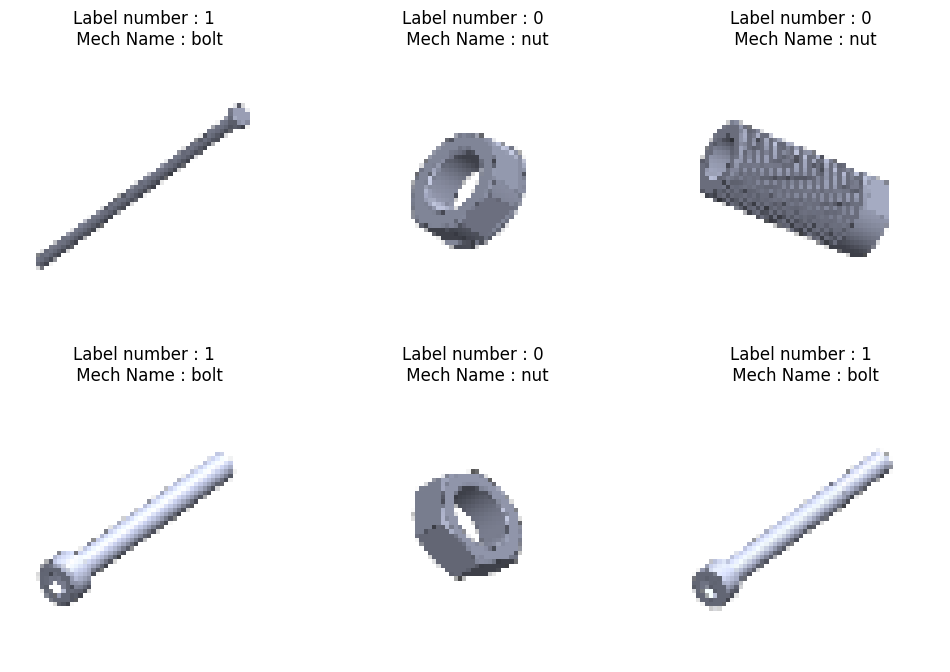

In [12]:
# 取出 Tensor 圖片來看看
plt.figure(figsize=(12, 8))
for index, (img, label) in enumerate(full_ds.take(6)):
    l = np.argmax(label.numpy())
    plt.subplot(2, 3, index + 1)
    plt.imshow(img)
    plt.title("Label number : {} \n Mech Name : {}".format(l, rev_class_name[l]))
    plt.axis("off")

In [13]:
# 切割成 training data 與 validation data
train_len = int(0.8 * num_image)
val_len = num_image - train_len

train_ds = full_ds.take(train_len)
val_ds = full_ds.skip(train_len)

print("train size : ", train_len, " val size : ", val_len)

# 添加 batch
BATCH_SIZE = 32 

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

train size :  4873  val size :  1219


In [14]:
# 查看添加batch後的維度
trainiter = iter(train_ds)
x, y = trainiter.next()
print("training image batch shape : ", x.shape)
print("training label batch shape : ", y.shape)

training image batch shape :  (32, 64, 64, 3)
training label batch shape :  (32, 4)


# **5. 建立模型**

In [15]:
input_shape = (IMG_WIDTH , IMG_HEIGHT , 3)

# 自訂你的 model
model = keras.Sequential(
    [
        keras.Input(shape = input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Dropout(rate=0.3),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.GlobalAveragePooling2D(),
        layers.Dense(units=64, activation="relu"),
        layers.Dropout(rate=0.3),
        layers.Dense(units=4, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 64)               0

# **6. 制定訓練計畫**

In [16]:
from tensorflow.python.eager.monitoring import Metric
# todo
EPOCHS = 150   #隨便讓他多跑幾次

##########
# todo #
##########
# model.compile 決定 learning strategy、Loss calculator
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/150
153/153 [==============================] - 22s 65ms/step - loss: 1.2718 - accuracy: 0.3733 - val_loss: 1.3215 - val_accuracy: 0.3987
Epoch 2/150
153/153 [==============================] - 16s 90ms/step - loss: 1.2879 - accuracy: 0.3640 - val_loss: 1.2639 - val_accuracy: 0.5472
Epoch 3/150
153/153 [==============================] - 11s 61ms/step - loss: 1.1712 - accuracy: 0.4158 - val_loss: 0.9742 - val_accuracy: 0.5980
Epoch 4/150
153/153 [==============================] - 10s 53ms/step - loss: 0.9724 - accuracy: 0.5446 - val_loss: 0.9014 - val_accuracy: 0.6005
Epoch 5/150
153/153 [==============================] - 10s 49ms/step - loss: 0.9201 - accuracy: 0.5580 - val_loss: 0.8669 - val_accuracy: 0.6177
Epoch 6/150
153/153 [==============================] - 11s 58ms/step - loss: 0.8906 - accuracy: 0.5740 - val_loss: 0.8425 - val_accuracy: 0.6169
Epoch 7/150
153/153 [==============================] - 11s 59ms/step - loss: 0.8632 - accuracy: 0.5808 - val_loss: 0.8357 - val_ac

# **7. 評估模型**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


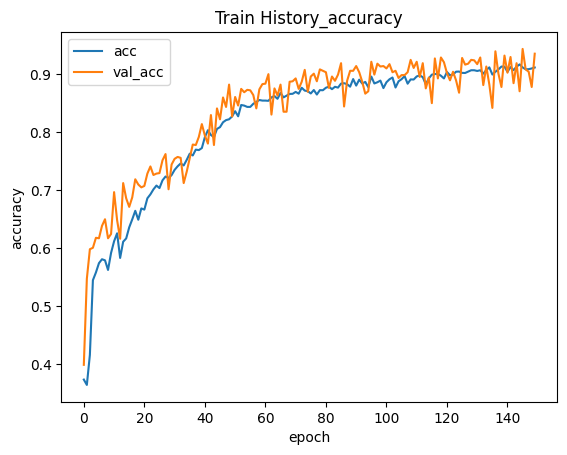

In [21]:
print(history.history.keys())

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Train History_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['acc','val_acc'], loc='upper left')
plt.show()

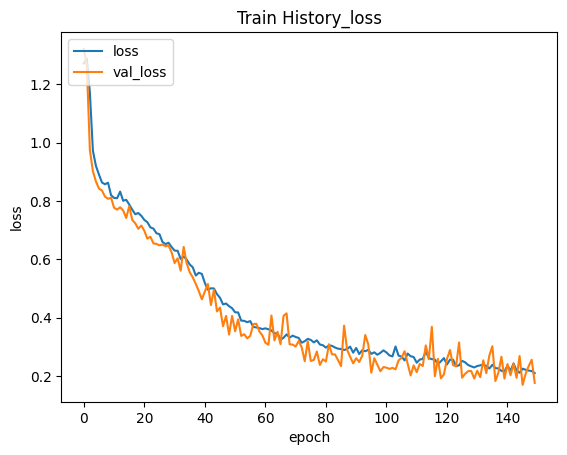

In [22]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train History_loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['loss','val_loss'], loc='upper left')
plt.show()

In [17]:
# 讀入測試資料並評估模型
list_of_test = glob.glob(test_dir + "**/*.png")
test_ds = make_dataset(list_of_test)
test_ds = test_ds.batch(BATCH_SIZE)
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

48/48 [==============================] - 1s 6ms/step - loss: 0.2211 - accuracy: 0.9265
Test loss: 0.22105100750923157
Test accuracy: 0.9265092015266418
